Date: 2016-10-21

In [248]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%qtconsole
import sys
import collections
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tqdm
import patsy
import statsmodels.api as sm
import statsmodels.formula.api as smf
import ripple_decoding
import ripple_detection
import scipy.stats

sys.path.append('../src/')
import data_filter

In [146]:
Animal = collections.namedtuple('Animal', {'directory', 'short_name'})
num_days = 8
days = range(1, num_days + 1)
animals = {'HPa': Animal(directory='HPa_direct', short_name='HPa')}

epoch_info = data_filter.make_epochs_dataframe(animals, days)
tetrode_info = data_filter.make_tetrode_dataframe(animals)
epoch_index = (epoch_info
    .loc[(['HPa'], [8]), :]
    .loc[epoch_info.environment == 'wtr1'].index)

cur_tetrode_info = tetrode_info[epoch_index[0]]
cur_tetrode_info

area  depth descrip  numcells tetrode_id
animal day epoch_ind tetrode_number                                          
HPa    8   2         1                CA1    113  riptet        12     HPa821
                     2                CA1    121     NaN         0     HPa822
                     3                CA1     90  CA1Ref         0     HPa823
                     4                CA1    116  riptet        15     HPa824
                     5                CA1    116  riptet         0     HPa825
                     6                CA1    110  riptet         0     HPa826
                     7                CA1    114  riptet         0     HPa827
                     8               iCA1    114  riptet         0     HPa828
                     9               iCA1    100  riptet         0     HPa829
                     10              iCA1     96     NaN         0    HPa8210
                     11              iCA1    106  riptet         0    HPa8211
                     12              iCA1    114  riptet         3    HPa8212
                     13              iCA1    120     NaN         0    HPa8213
                     14              iCA1    105  riptet         6    HPa8214
                     15               PFC     93     NaN         0    HPa8215
                     16               PFC     90     NaN         0    HPa8216
                     17               PFC     90     NaN         6    HPa8217
                     18               PFC     90     NaN         0    HPa8218
                     19               PFC    130     NaN         0    HPa8219
                     20               PFC    109     NaN         0    HPa8220

In [3]:
neuron_info = data_filter.make_neuron_dataframe(animals)
cur_neuron_info = (neuron_info[epoch_index[0]]
    .dropna()
    .query('(numspikes > 0) & (area == "CA1")'))
cur_neuron_info

area                   csi  \
animal day epoch_ind tetrode_number neuron_number                              
HPa    8   2         1              2              CA1   0.05963302752293578   
                                    3              CA1   0.19162790697674417   
                                    4              CA1   0.08121019108280254   
                                    5              CA1   0.14817320703653586   
                                    6              CA1    0.1690929451287794   
                                    7              CA1  0.053475935828877004   
                     4              1              CA1   0.09773936170212766   
                                    2              CA1   0.13846153846153847   
                                    3              CA1    0.1411764705882353   
                                    4              CA1   0.11428571428571428   
                                    5              CA1   0.04081632653061224   
                                    6              CA1   0.02981651376146789   
                                    7              CA1   0.16352201257861634   
                                    8              CA1   0.16104868913857678   

                                                              meanrate  \
animal day epoch_ind tetrode_number neuron_number                        
HPa    8   2         1              2               0.7218543046357616   
                                    3               0.8899006622516556   
                                    4               0.5198675496688742   
                                    5                2.447019867549669   
                                    6               0.7392384105960265   
                                    7              0.15480132450331127   
                     4              1               1.2450331125827814   
                                    2               1.1837748344370862   
                                    3               0.7740066225165563   
                                    4              0.23178807947019867   
                                    5              0.20281456953642385   
                                    6               0.3609271523178808   
                                    7               0.1316225165562914   
                                    8              0.22102649006622516   

                                                  numspikes  \
animal day epoch_ind tetrode_number neuron_number             
HPa    8   2         1              2                   872   
                                    3                  1075   
                                    4                   628   
                                    5                  2956   
                                    6                   893   
                                    7                   187   
                     4              1                  1504   
                                    2                  1430   
                                    3                   935   
                                    4                   280   
                                    5                   245   
                                    6                   436   
                                    7                   159   
                                    8                   267   

                                                            propbursts  \
animal day epoch_ind tetrode_number neuron_number                        
HPa    8   2         1              2               0.2305045871559633   
                                    3               0.6409302325581395   
                                    4               0.3200636942675159   
                                    5               0.4983085250338295   
                                    6               0.5442329227323628   
                                    7              0.2085

In [4]:
trial_info = data_filter.get_interpolated_position_dataframe(epoch_index[0], animals)
trial_info

,trajectory_category_ind,trajectory_direction,trajectory_turn,trial_number,linear_distance,x_position,y_position,head_direction,speed,linear_position
time,,,,,,,,,,
2712.994800,0.0,Outbound,Left,1.0,0.931162,96.411070,105.570044,-0.244134,3.076491,0.931235
2712.995467,0.0,Outbound,Left,1.0,0.931162,96.411070,105.570044,-0.244134,3.076491,0.931235
2712.996133,0.0,Outbound,Left,1.0,0.931162,96.411070,105.570044,-0.244134,3.076491,0.931235
2712.996800,0.0,Outbound,Left,1.0,0.931162,96.411070,105.570044,-0.244134,3.076491,0.931235
2712.997467,0.0,Outbound,Left,1.0,0.931162,96.411070,105.570044,-0.244134,3.076491,0.931235
2712.998133,0.0,Outbound,Left,1.0,0.931162,96.411070,105.570044,-0.244134,3.076491,0.931235
2712.998800,0.0,Outbound,Left,1.0,0.931162,96.411070,105.570044,-0.244134,3.076491,0.931235
2712.999467,0.0,Outbound,Left,1.0,0.931162,96.411070,105.570044,-0.244134,3.076491,0.931235
2713.000133,0.0,Outbound,Left,1.0,0.931162,96.411070,105.570044,-0.244134,3.076491,0.931235


In [8]:
spikes_data = [data_filter.get_spike_indicator_dataframe(neuron_index, animals)
               for neuron_index in cur_neuron_info.index]
spikes_data[0]

,is_spike
time,
2712.994800,0
2712.995467,0
2712.996133,0
2712.996800,0
2712.997467,0
2712.998133,0
2712.998800,0
2712.999467,0
2713.000133,0


### Only train on data when the rat is moving

In [110]:
train_trial_info = trial_info.query('speed > 4')
train_spikes_data = [data_filter.filter_dataframe_by_dataframe(spikes_datum, train_trial_info)
                     for spikes_datum in spikes_data]

### Encoding Model

#### Train model

In [ ]:
formula = '1 + trajectory_direction * bs(linear_distance, df=10, degree=3)';
design_matrix = patsy.dmatrix(formula, train_trial_info, return_type='dataframe')
fit = [sm.GLM(spikes, design_matrix, family=sm.families.Poisson()).fit(maxiter=30)
       for spikes in tqdm.tqdm_notebook(train_spikes_data, desc='fit')]

#### Get predicted conditional intensities

In [139]:
linear_distance_grid = np.linspace(0, 192, 49)
linear_distance_grid_centers = linear_distance_grid[:-1] + np.diff(linear_distance_grid) / 2

def predictors_by_trajectory_direction(trajectory_direction, linear_distance_grid_centers, design_matrix):
    predictors = {'linear_distance': linear_distance_grid_centers,
                  'trajectory_direction': [trajectory_direction] * len(linear_distance_grid_centers)}
    return patsy.build_design_matrices([design_matrix.design_info], predictors)[0]

inbound_predict_design_matrix = predictors_by_trajectory_direction('Inbound',
                                                                   linear_distance_grid_centers,
                                                                   design_matrix)
outbound_predict_design_matrix = predictors_by_trajectory_direction('Outbound',
                                                                    linear_distance_grid_centers,
                                                                    design_matrix)

def get_conditional_intensity(fit, predict_design_matrix):
    return np.vstack([fitted_model.predict(predict_design_matrix)
                      for fitted_model in fit]).T

inbound_conditional_intensity = get_conditional_intensity(fit, inbound_predict_design_matrix)
outbound_conditional_intensity = get_conditional_intensity(fit, outbound_predict_design_matrix)

#### Plot model fits for each neuron to check fit quality
Neurons HPa8245 and HPa8248 appear to have poor fits. What should we do about poor fits?

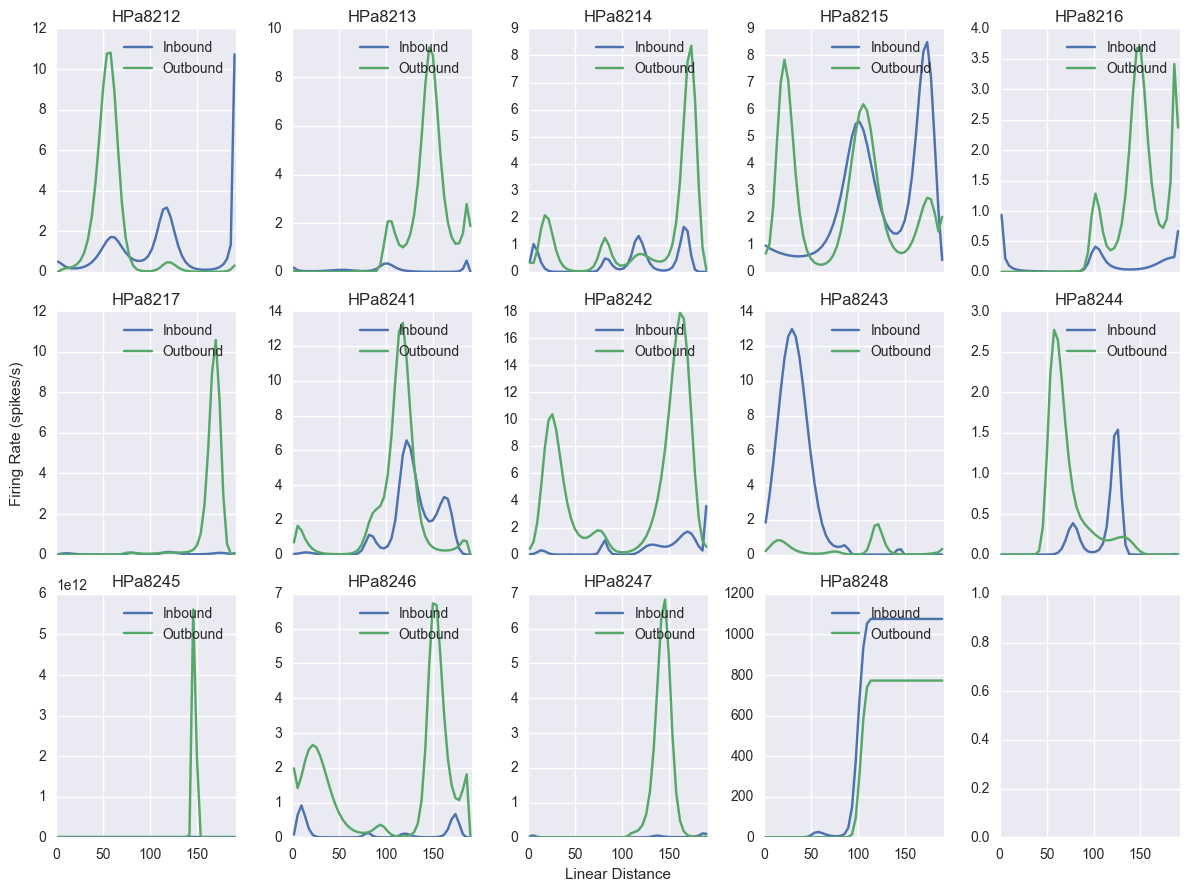

In [91]:
num_neurons = len(fit)
col_wrap = 5
num_plot_rows = int(np.ceil(num_neurons / col_wrap))
fig, axes = plt.subplots(nrows=num_plot_rows, ncols=col_wrap, figsize=(12, 9), sharex=True)
sampling_frequency = 1500

for neuron_ind, ax in enumerate(axes.flatten()[:num_neurons]):
    ax.plot(linear_position_grid_centers,
            fit[neuron_ind].predict(inbound_predict_design_matrix) * sampling_frequency,
            label='Inbound')
    ax.plot(linear_position_grid_centers,
            fit[neuron_ind].predict(outbound_predict_design_matrix) * sampling_frequency,
            label='Outbound')
    ax.legend()
    ax.set_xlim((linear_distance_grid.min(), linear_distance_grid.max()))
    ax.set_title(cur_neuron_info.neuron_id[neuron_ind])

middle_column = int(np.ceil(col_wrap / 2) - 1)
middle_row = int(np.ceil(num_plot_rows / 2) - 1)
axes[-1, middle_column].set_xlabel('Linear Distance')
axes[middle_row, 0].set_ylabel('Firing Rate (spikes/s)')
plt.tight_layout()

#### Compare to raw spikes

### State Transition Matrix

#### Fit transition matrix based on movement data
Estimate separately based on inbound and outbound movements

In [30]:
inbound_state_transitions = ripple_decoding.empirical_movement_transition_matrix(
    train_trial_info[train_trial_info.trajectory_direction == 'Inbound'].linear_distance, linear_distance_grid)
outbound_state_transitions = ripple_decoding.empirical_movement_transition_matrix(
    train_trial_info[train_trial_info.trajectory_direction == 'Outbound'].linear_distance, linear_distance_grid)

/Users/edeno/anaconda3/envs/Jadhav-2016-Data-Analysis/lib/python3.5/site-packages/numpy/lib/function_base.py:804: RuntimeWarning: invalid value encountered in greater_equal
  not_smaller_than_edge = (sample[:, i] >= edges[i][-1])


#### Plot state transition matrix to check quality

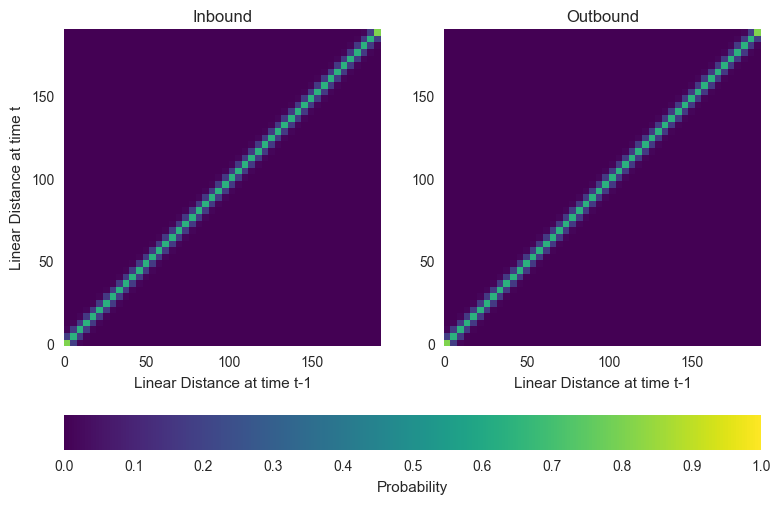

In [107]:
def plot_state_transition(state_transition, grid, ax=None):
    if ax is None:
        ax = plt.gca()
    x_grid, y_grid = np.meshgrid(grid, grid)
    mesh = ax.pcolormesh(x_grid, y_grid, state_transition,
                         cmap='viridis', vmin=0, vmax=1)
    grid_extent = (grid.min(), grid.max())
    ax.set_xlim(grid_extent)
    ax.set_ylim(grid_extent)
    ax.set_aspect('equal')
    return mesh
    
fig, ax = plt.subplots(1, 2, figsize=(9,6))
plot_state_transition(inbound_state_transitions, linear_distance_grid, ax=ax[0])
ax[0].set_xlabel('Linear Distance at time t-1')
ax[0].set_ylabel('Linear Distance at time t')
ax[0].set_title('Inbound')
mesh = plot_state_transition(outbound_state_transitions, linear_distance_grid, ax=ax[1])
ax[1].set_title('Outbound')
ax[1].set_xlabel('Linear Distance at time t-1')

fig.colorbar(mesh, ax=ax.ravel().tolist(), label='Probability', orientation='horizontal')

#### Make sure state transition columns sum to 1

In [133]:
error_tolerance = 1E-13
check_error = lambda x: np.all(np.abs(x - 1) < error_tolerance)
print(check_error(np.sum(inbound_state_transitions, axis=0)))
print(check_error(np.sum(outbound_state_transitions, axis=0)))

True
True


### Initial conditions
Where the replay trajectory starts.

The **outbound** inital condition is a Gaussian with probability mass at center arm reflecting that the replay trajectory is likely to start at the center arm

The **inbound** inital condition is a Gaussian with probability mass everywhere but at the center arm reflecting that the replay trajectory is likely to start everywhere except at the center arm

In [136]:
linear_distance_grid_bin_size = linear_distance_grid[1] - linear_distance_grid[0]

outbound_initial_conditions = ripple_decoding.normalize_to_probability(
    scipy.stats.norm.pdf(linear_distance_grid_centers, 0, linear_distance_grid_bin_size * 2))

inbound_initial_conditions = ripple_decoding.normalize_to_probability(
    (np.max(outbound_initial_conditions) * np.ones(linear_distance_grid_centers.shape)) - \
    outbound_initial_conditions)

#### Plot intial conditions

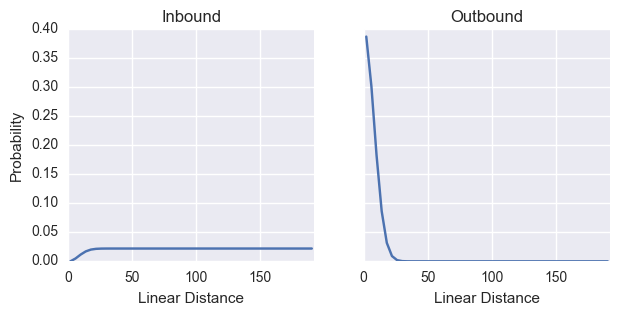

In [138]:
fig, ax = plt.subplots(1, 2, figsize=(7, 3), sharex=True, sharey=True)
ax[0].plot(linear_distance_grid_centers, inbound_initial_conditions)
ax[0].set_ylabel('Probability')
ax[0].set_xlabel('Linear Distance')
ax[0].set_title('Inbound')
ax[0].set_xlim((linear_distance_grid.min(), linear_distance_grid.max()))
ax[1].plot(linear_distance_grid_centers, outbound_initial_conditions)
ax[1].set_xlabel('Linear Distance')
ax[1].set_title('Outbound')
ax[1].set_xlim((linear_distance_grid.min(), linear_distance_grid.max()));

### Organize into discrete states
Outbound reverse is the same as inbound forward. Double check conditional intensity

In [345]:
import scipy.linalg
discrete_state_names = ['outbound_forward', 'outbound_reverse', 'inbound_forward', 'inbound_reverse']

# Initial Conditions
num_decision_states = len(discrete_state_names)
prior_probability_of_state = 1 / num_decision_states
initial_conditions = np.hstack([outbound_initial_conditions,
                                inbound_initial_conditions,
                                inbound_initial_conditions,
                                outbound_initial_conditions]) * prior_probability_of_state

# State Transition
state_transition = scipy.linalg.block_diag(outbound_state_transitions,
                                           inbound_state_transitions,
                                           inbound_state_transitions,
                                           outbound_state_transitions)

# Encoding Model
conditional_intensity = np.vstack([outbound_conditional_intensity,
                                   outbound_conditional_intensity,
                                   inbound_conditional_intensity,
                                   inbound_conditional_intensity])

combined_likelihood_params = dict(likelihood_function=ripple_decoding.instantaneous_poisson_likelihood,
                                  likelihood_kwargs=dict(conditional_intensity=conditional_intensity))

## Ripple decoding

#### Get ripples
Maybe there's a better way to exclude ripples with speed > 4

In [247]:
ripple_times = ripple_detection.get_computed_consensus_ripple_times(epoch_index[0], animals)
test_trial_info = trial_info.query('speed <= 4')
filtered_spikes_data = [data_filter.filter_dataframe_by_dataframe(spikes_datum, train_trial_info)
                     for spikes_datum in spikes_data]
spike_ripples_df = list(ripple_detection.reshape_to_segments(
        filtered_spikes_data, ripple_times, concat_axis=1))

num_ripples = len(ripple_times)

test_spikes = [np.vstack([df.iloc[:, ripple_ind].dropna().values
               for df in spike_ripples_df]).T
               for ripple_ind in np.arange(num_ripples)]

#### Decode Ripples

In [413]:
import functools
decode_ripple = functools.partial(ripple_decoding.predict_state,
                                   initial_conditions=initial_conditions,
                                   state_transition=state_transition,
                                   likelihood_function=ripple_decoding.combined_likelihood,
                                   likelihood_kwargs=combined_likelihood_params)

posterior_density = [decode_ripple(ripple_spikes)
                     for ripple_spikes in test_spikes]

def compute_decision_state_probability(posterior_density, num_decision_states):
    num_time = len(posterior_density)
    new_shape = (num_time, num_decision_states, -1)
    return np.sum(np.reshape(posterior_density, new_shape), axis=2)
                  
decision_state_probability = [compute_decision_state_probability(density, num_decision_states)
                              for density in posterior_density]

def compute_max_state(probability):
    end_time_probability = probability[-1, :]
    return (discrete_state_names[np.argmax(end_time_probability)],
            np.max(end_time_probability))

max_state = pd.DataFrame([compute_max_state(probability)
                         for probability in decision_state_probability],
                         columns=['ripple_type', 'ripple_state_probability'],
                         index=pd.Index(np.arange(num_ripples) + 1, name='ripple_number'))

threshold = 0.8
max_state[max_state.ripple_state_probability > threshold].ripple_type.value_counts()

outbound_forward    19
inbound_reverse     14
outbound_reverse     7
inbound_forward      1
Name: ripple_type, dtype: int64

#### Display ripple category probabilities

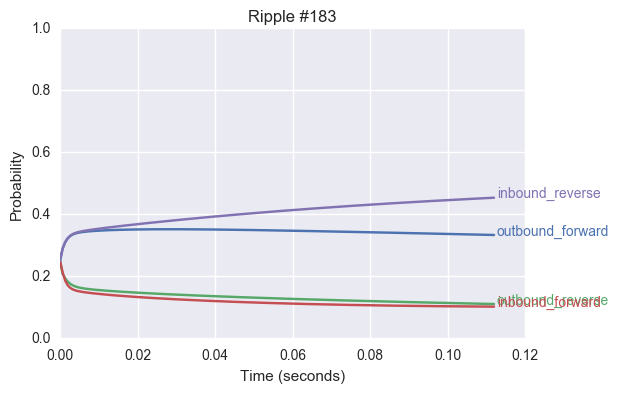

In [398]:
import ipywidgets

def browse_ripple_fits(decision_state_probability, discrete_state_names, sampling_frequency=1500):
    def plot_fits(ripple_ind):
        time_length = decision_state_probability[ripple_ind].shape[0]
        time = np.arange(time_length) / sampling_frequency
        lineObjects = plt.plot(time, decision_state_probability[ripple_ind])
        # plt.legend(lineObjects, discrete_state_names)
        for state_ind, state_names in enumerate(discrete_state_names):
                plt.text(time[-1] + (1 / sampling_frequency),
                         decision_state_probability[ripple_ind][-1, state_ind],
                         discrete_state_names[state_ind],
                         color=lineObjects[state_ind].get_color())
        plt.ylim((0, 1))
        plt.xlabel('Time (seconds)')
        plt.ylabel('Probability')
        plt.title('Ripple #{ripple_number}'.format(ripple_number=ripple_ind+1))
    ipywidgets.interact(plot_fits, ripple_ind=(0, len(decision_state_probability)-1))
        
browse_ripple_fits(decision_state_probability, discrete_state_names)